# Collation with decision graph

## Data

In [1]:
# two witnesses, with repetition and transposition

w1 = """the red and the black cat"""
w2 = """the black and the red cat"""

## Construct list of ngrams shared by witnesses

Find ngrams and positions in witnesses

### Tokenize witnesses

In [2]:
def tokenize_witnesses(w1_string, w2_string):
    '''Return list of witnesses, each represented by a list of tokens'''
    # TODO: handle punctuation, upper- ~ lowercase
    w1_tokens = w1.split()
    w2_tokens = w2.split()
    witnesses = [w1_tokens, w2_tokens]
    return witnesses

In [3]:
witnesses = tokenize_witnesses(w1, w2)
print(witnesses) # take a look

[['the', 'red', 'and', 'the', 'black', 'cat'], ['the', 'black', 'and', 'the', 'red', 'cat']]


### Find ngrams shared by the witnesses

In [4]:
from collections import defaultdict

def compute_ngrams_all(witness):
    '''Create n-grams and returns offsets and lengths

    Argument:
    witness:list -- list of tokens in witness

    Returns:
    ngrams:dict --       key is ngram
                         value is list of start positions in witness for ngram
    token_counts:dict -- key is ngram
                         value is token count of ngram
    '''
    ngram_offsets = defaultdict(list)
    token_counts = {}
    for n in range(1, len(witness) + 1):
        for i in range(len(witness)-n+1):
            g = ' '.join(witness[i:i+n]) # store each ngram as g temporarily
            ngram_offsets[g].append(i)
            token_counts[g] = n
    return ngram_offsets, token_counts

In [5]:
ngram_offsets_by_witness_dict = {} # keyed by witness
ngram_lengths = {}
for index, witness in enumerate(witnesses):
    map1, map2 = compute_ngrams_all(witness)
    ngram_offsets_by_witness_dict['w' + str(index + 1)] = map1
    ngram_lengths.update(map2)

In [6]:
# Look at ngram lists for each witness
# Keys of inner dictionary are ngrams, values are lists of start positions in witness
for key in ngram_offsets_by_witness_dict.keys():
    print('Witness ' + key)
    print(ngram_offsets_by_witness_dict[key])
    print()

Witness w1
defaultdict(<class 'list'>, {'the': [0, 3], 'red': [1], 'and': [2], 'black': [4], 'cat': [5], 'the red': [0], 'red and': [1], 'and the': [2], 'the black': [3], 'black cat': [4], 'the red and': [0], 'red and the': [1], 'and the black': [2], 'the black cat': [3], 'the red and the': [0], 'red and the black': [1], 'and the black cat': [2], 'the red and the black': [0], 'red and the black cat': [1], 'the red and the black cat': [0]})

Witness w2
defaultdict(<class 'list'>, {'the': [0, 3], 'black': [1], 'and': [2], 'red': [4], 'cat': [5], 'the black': [0], 'black and': [1], 'and the': [2], 'the red': [3], 'red cat': [4], 'the black and': [0], 'black and the': [1], 'and the red': [2], 'the red cat': [3], 'the black and the': [0], 'black and the red': [1], 'and the red cat': [2], 'the black and the red': [0], 'black and the red cat': [1], 'the black and the red cat': [0]})



In [7]:
# Look at ngram lengths (combined)
print(ngram_lengths)

{'the': 1, 'red': 1, 'and': 1, 'black': 1, 'cat': 1, 'the red': 2, 'red and': 2, 'and the': 2, 'the black': 2, 'black cat': 2, 'the red and': 3, 'red and the': 3, 'and the black': 3, 'the black cat': 3, 'the red and the': 4, 'red and the black': 4, 'and the black cat': 4, 'the red and the black': 5, 'red and the black cat': 5, 'the red and the black cat': 6, 'black and': 2, 'red cat': 2, 'the black and': 3, 'black and the': 3, 'and the red': 3, 'the red cat': 3, 'the black and the': 4, 'black and the red': 4, 'and the red cat': 4, 'the black and the red': 5, 'black and the red cat': 5, 'the black and the red cat': 6}


In [8]:
# find keys shared by *all* witnesses
shared_ngrams = set(ngram_offsets_by_witness_dict["w1"].keys())
for value in ngram_offsets_by_witness_dict.values():
    shared_ngrams = shared_ngrams.intersection(value.keys())

shared_ngrams # take a look

{'and', 'and the', 'black', 'cat', 'red', 'the', 'the black', 'the red'}

### Use shared ngrams to find potential alignments

In [9]:
# output format: {ngram : [(0,1), (2,3)]}, where
#   the two entries in each tuple are for witnesses A and B
potential_alignments = defaultdict(list)
for ngram in shared_ngrams:
    for w1_offset in ngram_offsets_by_witness_dict['w1'][ngram]:
        for w2_offset in ngram_offsets_by_witness_dict['w2'][ngram]:
            potential_alignments[ngram].append((w1_offset, w2_offset))

print(potential_alignments)

defaultdict(<class 'list'>, {'black': [(4, 1)], 'the black': [(3, 0)], 'the': [(0, 0), (0, 3), (3, 0), (3, 3)], 'and': [(2, 2)], 'cat': [(5, 5)], 'red': [(1, 4)], 'the red': [(0, 3)], 'and the': [(2, 2)]})


### Invert keys and values for potential alignments

* Keys are now individual tuples of (A, B) start positions
* Values are now lists of ngrams of different lengths at those positions

In [10]:
alignments = defaultdict(list)
for key,value in potential_alignments.items():
    for t in value:
        alignments[t].append(key)

print(alignments)

defaultdict(<class 'list'>, {(4, 1): ['black'], (3, 0): ['the black', 'the'], (0, 0): ['the'], (0, 3): ['the', 'the red'], (3, 3): ['the'], (2, 2): ['and', 'and the'], (5, 5): ['cat'], (1, 4): ['red']})


### Create bitarrays of all potentials to track committed tokens

Keys are tuples of A-start, B-start, ngram
Values are bitarrays the length of the witness token-count, with bits set for ngram

Why? To avoid having to recompute each time we compare. To compare:

1. Compute bitarray for pattern being tested
1. Perform bitwise "and" operation (`&`) on pattern being tested and pattern to which it is being compared
1. Yields 0 result only if the two have no bits in common, i.e., no overlap

In [11]:
# globals
from bitarray import bitarray
bitarray_A = bitarray(len(witnesses[0]))
bitarray_A.setall(0)
bitarray_B = bitarray(len(witnesses[1]))
bitarray_B.setall(0)

In [12]:
def compute_bitarray(pattern:tuple) -> dict:
    '''Compute bitarray for (A, B, 'ngram')

    Arguments:

    pattern:tuple -- (A, B, 'ngram1')

    Returns dictionary with keys 'A', 'B'
    '''
    ngram_length = ngram_lengths[pattern[2]]
    ba_A = bitarray(bitarray_A)
    ba_A[pattern[0]: pattern[0] + ngram_length] = 1
    ba_B = bitarray(bitarray_B)
    ba_B[pattern[1]: pattern[1] + ngram_length] = 1
    return {'A': ba_A, 'B': ba_B}

In [13]:
# test compute_bitarray function

compute_bitarray((0, 3, 'the red'))

{'A': bitarray('110000'), 'B': bitarray('000110')}

In [14]:
# precompute bitarrays for all (A, B, 'ngram') combinations as dictionary (tuple key) of dictionaries ('A' or 'B' key)
committed_tokens = {} # (A,B,'ngram') : {'A': 0000110, 'B': 000100}, for token positions in two witnesses
for location, ngrams in alignments.items(): # may contain multiple ngrams at same location
    for ngram in ngrams:
        committed_tokens[(location[0], location[1], ngram)] = compute_bitarray((location[0], location[1], ngram))
committed_tokens # take a look

{(4, 1, 'black'): {'A': bitarray('000010'), 'B': bitarray('010000')},
 (3, 0, 'the black'): {'A': bitarray('000110'), 'B': bitarray('110000')},
 (3, 0, 'the'): {'A': bitarray('000100'), 'B': bitarray('100000')},
 (0, 0, 'the'): {'A': bitarray('100000'), 'B': bitarray('100000')},
 (0, 3, 'the'): {'A': bitarray('100000'), 'B': bitarray('000100')},
 (0, 3, 'the red'): {'A': bitarray('110000'), 'B': bitarray('000110')},
 (3, 3, 'the'): {'A': bitarray('000100'), 'B': bitarray('000100')},
 (2, 2, 'and'): {'A': bitarray('001000'), 'B': bitarray('001000')},
 (2, 2, 'and the'): {'A': bitarray('001100'), 'B': bitarray('001100')},
 (5, 5, 'cat'): {'A': bitarray('000001'), 'B': bitarray('000001')},
 (1, 4, 'red'): {'A': bitarray('010000'), 'B': bitarray('000010')}}

### Create function to compare bitarrays to check for overlap

Logical and (`&`) returns 1 for overlapping bits. `.any()` method of bitarray object returns True if any bit is set.

In [15]:
def compare_bitarrays(new:bitarray, old:bitarray) -> bool:
    '''Compare two bitarrays, return true if overlap

    Retrieves values from precomputed dictionary of all possible (A, B, 'ngram') tuples

    Arguments:
        new:bitarray
        old:bitarray
    '''
    return (new & old).any()

In [16]:
# test comparisons
with_overlap = compare_bitarrays(committed_tokens[(0, 3, 'the')]['A'], \
                                 committed_tokens[(0, 3, 'the red')]['A']) # true because overlap
print(with_overlap)
without_overlap = compare_bitarrays(committed_tokens[(0,3,'the')]['A'], \
                                    committed_tokens[(5, 5, 'cat')]['A']) # false because no overlap
print(without_overlap)

True
False


In [17]:
def add_to_bitarray(new:bitarray, old:bitarray):
    '''Add new bitarray to accumulated one with logical or (|)

    Used in loop to build cumulative bitarray to store state of all committed patterns

    Arguments:
        new:bitarray -- bitarray for a new pattern (from compute_bitarray(pattern:tuple))
        old:bitarray -- accumulated bitarray
    '''
    return (new | old)

In [18]:
# test add_to_bitarray
old = bitarray(bitarray_A) # initialize as all zeros
for k, v in committed_tokens.items(): # initialized above as (A, B, 'ngram') : {'A': ba_A, 'B': ba_B}
    old = add_to_bitarray(v['A'], old) # logical or with new bitarray
    print('New data: ' + str(v['A']) + ', interim result: ' + str(old)) # interim new bitarray and new result
print('Final result: ' + str(old))

New data: bitarray('000010'), interim result: bitarray('000010')
New data: bitarray('000110'), interim result: bitarray('000110')
New data: bitarray('000100'), interim result: bitarray('000110')
New data: bitarray('100000'), interim result: bitarray('100110')
New data: bitarray('100000'), interim result: bitarray('100110')
New data: bitarray('110000'), interim result: bitarray('110110')
New data: bitarray('000100'), interim result: bitarray('110110')
New data: bitarray('001000'), interim result: bitarray('111110')
New data: bitarray('001100'), interim result: bitarray('111110')
New data: bitarray('000001'), interim result: bitarray('111111')
New data: bitarray('010000'), interim result: bitarray('111111')
Final result: bitarray('111111')


### Convert alignments dictionary to sorted list of tuples, where ngrams within are sorted tuples of strings

* Tuples are (A-position:int, B-position:int, ngrams), sorted by A position from left to right
* Ngrams are tuples of all ngrams at that position, sorted from longest to shorted

Note: Use tuple instead of list for ngrams to support sorting; this functions as a frozen list

In [19]:
import collections
sorted_alignments_witness_A = []
for key in sorted(alignments):
    sorted_alignments_witness_A.append((key[0],key[1], tuple(sorted(alignments[key], key=lambda x: ngram_lengths[x], reverse=True))))

print(sorted_alignments_witness_A)

[(0, 0, ('the',)), (0, 3, ('the red', 'the')), (1, 4, ('red',)), (2, 2, ('and the', 'and')), (3, 0, ('the black', 'the')), (3, 3, ('the',)), (4, 1, ('black',)), (5, 5, ('cat',))]


In [20]:
# Does it work?
for entry in sorted_alignments_witness_A:
    print(entry)

(0, 0, ('the',))
(0, 3, ('the red', 'the'))
(1, 4, ('red',))
(2, 2, ('and the', 'and'))
(3, 0, ('the black', 'the'))
(3, 3, ('the',))
(4, 1, ('black',))
(5, 5, ('cat',))


In [21]:
# Also sort by witness B
sorted_alignments_witness_B = sorted(sorted_alignments_witness_A, key=lambda x:(x[1], x[0]))
sorted_alignments_witness_B # take a look

[(0, 0, ('the',)),
 (3, 0, ('the black', 'the')),
 (4, 1, ('black',)),
 (2, 2, ('and the', 'and')),
 (0, 3, ('the red', 'the')),
 (3, 3, ('the',)),
 (1, 4, ('red',)),
 (5, 5, ('cat',))]

## Build the decision graph

### Node subdictionary, keyed by node id, stores the following properties

Key is unique integer

Properties:

* **id**:int (same as key for this node)
* **current-location-in-A**:int (last token position committed in witness A)
* **current-location-in-B**:int (last token position committed in witness A)
* **aligned-patterns**:list [(offsetA:int, offsetB:int, ngram:str)], where offsets are start positions of ngrams
* **transposed-patterns**:list [(offsetA:int, offsetB:int, ngram:str)], where offsets are start positions of ngrams
* **potential-alignments-by-A**:list [(offsetA:int, offsetB:int, ngram:str)]
* **potential-alignments-by-B**:list [(offsetB:int, offsetA:int, ngram:str)]

### Internal edge subdictionaries, for incoming and outgoing edges

Key is id of parent or child for outgoing and incoming subdictionaries, respectively

Value is list of ids of parents or children for incoming and outgoing subdictionaries, respectively

In [22]:
# Create outer dictionary for decision tree nodes
decision_graph = {}

# Create inner dictionaries for nodes and edges

decision_graph['nodes'] = defaultdict(dict)
decision_graph['edges'] = {}
decision_graph['edges']['incoming'] = defaultdict(list)
decision_graph['edges']['outgoing'] = defaultdict(list)

decision_graph # take a look

{'nodes': defaultdict(dict, {}),
 'edges': {'incoming': defaultdict(list, {}),
  'outgoing': defaultdict(list, {})}}

### Keep track of nodes by position value in dataframe

Columns:

* **start_A**:int
* **end_A**:int
* **start_B**:int
* **end_B**:int
* **best_sum**:int               Best sum of tokens in alignments and potential alignments for that set of four positions

For each new node:

**TODO:** Is this correct?

1. If the df does not have an entry at that position: create new row
2. If the df already has an entry at that position, compare best_sum for aligned and potential patterns
   (Note: avoid double-counting tokens with subpatterns)
    1. If the best_sum of new item already in df at location (by both start and end nodes) is higher than new node
        1. Don't add new node to graph
        1. Don't update df
    1. If the best_sum of new item is higher (better) than the existing one
        1. Add new node to graph
        1. Update best_sum in df with new higher value
        1. (TODO: Prune nodes now discovered to be suboptimal)
    1. If the new sum is the same as the existing one
        1. Add new node to graph

In [23]:
# Computes weights used to make ... er ... decisions
# Counts tokens, not patterns
def count_tokens(patterns:list) -> int:
    '''Count tokens covered by list of patterns, accounting for overlap

    Since patterns are shared by witness, just count for A

    Arguments:
    patterns:list -- list of aligned or potential patterns
    '''
    token_positions = [] # list of integers, with duplicates
    for pattern in patterns: # check each aligned or potential pattern
        ngram_length = ngram_lengths[pattern[2][0]] # token length
        committed_tokens = list(range(pattern[0], pattern[0] + ngram_length)) # expand range
        token_positions.append(committed_tokens) # append committed token positions for current pattern
    return len(set(item for sublist in token_positions for item in sublist)) # flatten, deduplicate, count

def compute_pattern_sum(node: dict) -> int:
    '''Compute sum of alignments and potential alignments

    Higher values are better

    Arguments:
    node:dict -- node to evaluate (look at 'aligned-patterns' and 'potential-alignments-by-A' properties)
    '''
    return count_tokens(node['aligned-patterns']) + \
        count_tokens(node['potential-alignments-by-A'])

In [24]:
# test count_tokens() function
test1 = [(0, 0, ('the',)), (0, 3, ('the red', 'the')), (1, 4, ('red',))]
print(count_tokens(test1)) # returns 2, since positions 0 and 1 are committed in A)
test2 = [(3, 0, ('the black', 'the')), (3, 3, ('the',)), (4, 1, ('black',)), (5, 5, ('cat',))]
print(count_tokens(test2)) # returns 3, since positions 3, 4, and 5 are committed in A

2
3


In [25]:
# test compute_pattern_sum() function
# Note: fake data
test = {'id': 0, \
 'aligned-patterns': [(0, 0, ('the',)), (0, 3, ('the red', 'the')), (1, 4, ('red',))], \
 'transposed-patterns': [], \
 'potential-alignments-by-A': [(5, 5, ('cat',))],
       }
print(compute_pattern_sum(test)) # returns 3 because 0 and 1 are committed as aligned in A and 5 as potential

3


In [26]:
import pandas as pd
import numpy as np

node_tracker = pd.DataFrame({'start_A': pd.Series([], dtype='int'), \
                             'end_A': pd.Series([], dtype='int'), \
                             'start_B': pd.Series([], dtype='int'), \
                             'end_B': pd.Series([], dtype='int'), \
                             'best_sum': pd.Series([], dtype='int') \
                            })
node_tracker # take a look

,start_A,end_A,start_B,end_B,best_sum


### Add root note to graph

No edges yet

In [27]:
decision_graph['nodes'][0] = {}

# Supply properties for root node
decision_graph['nodes'][0]['id'] = 0 # what's my key?
decision_graph['nodes'][0]['type'] = None # normally 'align' or 'transpose'
decision_graph['nodes'][0]['current-location-in-A'] = -1 # 0 would be the first position
decision_graph['nodes'][0]['current-location-in-B'] = -1
decision_graph['nodes'][0]['aligned-patterns'] = []
decision_graph['nodes'][0]['transposed-patterns'] = []
decision_graph['nodes'][0]['potential-alignments-by-A'] = sorted_alignments_witness_A
decision_graph['nodes'][0]['potential-alignments-by-B'] = sorted_alignments_witness_B

In [28]:
# Take a look at nodes (just root node)
# Don't bother with edges; there aren't any yet
decision_graph['nodes'][0]

{'id': 0,
 'type': None,
 'current-location-in-A': -1,
 'current-location-in-B': -1,
 'aligned-patterns': [],
 'transposed-patterns': [],
 'potential-alignments-by-A': [(0, 0, ('the',)),
  (0, 3, ('the red', 'the')),
  (1, 4, ('red',)),
  (2, 2, ('and the', 'and')),
  (3, 0, ('the black', 'the')),
  (3, 3, ('the',)),
  (4, 1, ('black',)),
  (5, 5, ('cat',))],
 'potential-alignments-by-B': [(0, 0, ('the',)),
  (3, 0, ('the black', 'the')),
  (4, 1, ('black',)),
  (2, 2, ('and the', 'and')),
  (0, 3, ('the red', 'the')),
  (3, 3, ('the',)),
  (1, 4, ('red',)),
  (5, 5, ('cat',))]}

### Add root node to node_tracker dataframe

In [29]:
# To add row to df without copying:
#   df.loc[df.index.max() + 1] (note: must set 0 explicitly because max() errors on no rows)
#   See: https://stackoverflow.com/questions/10715965/add-one-row-to-pandas-dataframe
best_sum = compute_pattern_sum(decision_graph['nodes'][0])
node_tracker.loc[0] = [-1, -1, -1, -1, best_sum]

In [30]:
# take a look at the df
print(node_tracker.dtypes)
node_tracker

start_A     int64
end_A       int64
start_B     int64
end_B       int64
best_sum    int64
dtype: object


,start_A,end_A,start_B,end_B,best_sum
0,-1,-1,-1,-1,6


In [31]:
# Function to add child nodes recursively
#
# Note: Currently depth-first; would breadth-first be more efficient?
#
# Within children:
#   Update current location in A and B
#   Update aligned patterns
#   Update transposed patterns
#   Update potential alignments for A and B
#
# Add three types of nodes:
#
#   1. Align closest in both witnesses, advance both locations by 1
#      There should be zero or one of these
#   2. Align closest in one witness, but not the other, advance pointers different amounts
#      There should be zero or two or more, closest in witness A (but not B) and vice versa
#      May not be symmetrical because of repetition
#   3. Advance pointer by one in both witnesses, but no alignment
#      If we get to type 2, there should be one of type 3
#
# Uses globals:
#   node_tracker:pd.DataFrame()
#   decision_graph:dict
#   ngram_lengths:dict


def add_children(parent_id: int) -> dict: # children know their parents when they're called
    # get nearest matches in new child node and prepare to recur over its children
    # Sort the union of nearest matches for consistency during development; does not affect logic
    # This gets node types 1 and 2 (see comment above), but not 3
    nearest_A_matches = [item for item in decision_graph['nodes'][parent_id]['potential-alignments-by-A'] if item[0] == decision_graph['nodes'][parent_id]['potential-alignments-by-A'][0][0]]
    nearest_B_matches = [item for item in decision_graph['nodes'][parent_id]['potential-alignments-by-B'] if item[1] == decision_graph['nodes'][parent_id]['potential-alignments-by-B'][0][1]]
    nearest_matches = sorted({item for item in nearest_A_matches + nearest_B_matches})

    for child in nearest_matches:
        # child looks like: (1, 2, ('hi mon', 'hi')): start location in A, in B, ngrams at that location
        location = np.array([child[0], child[1]]) # to check for presence in node_tracker

        if (node_tracker[node_tracker.columns[:2]] == location).all(1).any(): # https://stackoverflow.com/questions/24761133/pandas-check-if-row-exists-with-certain-values, (df == a).all(1).any()
            # https://stackoverflow.com/questions/21800169/python-pandas-get-index-of-rows-which-column-matches-certain-value
            # node is already in graph, so:
            #   add new edges
            id = node_tracker.index[((node_tracker['start_A'] == child[0]) & (node_tracker['start_B'] == child[1]))][0] # index of node in dataframe
            decision_graph['edges']['incoming'][id].append(parent_id)
            decision_graph['edges']['outgoing'][parent_id].append(id)
            #   TODO: if weight is better, update node (aligned and transposed patterns) and sum in df
        else: # add new node to graph and df, add new edges
            #################################
            # Add new node to graph
            #################################
            current_ngram_length = ngram_lengths[child[2][0]]
            id = len(decision_graph['nodes'])
            decision_graph['nodes'][id] = {} # create new node
            decision_graph['nodes'][id]['id'] = id
            if child[0] == decision_graph['nodes'][parent_id]['potential-alignments-by-A'][0][0] and child[1] == decision_graph['nodes'][parent_id]['potential-alignments-by-B'][0][1]:
                decision_graph['nodes'][id]['type'] = 'closest-in-both'
            else:
                decision_graph['nodes'][id]['type'] = 'closest-in-one'
            decision_graph['nodes'][id]['current-location-in-A'] = child[0] + current_ngram_length - 1
            decision_graph['nodes'][id]['current-location-in-B'] = child[1] + current_ngram_length - 1

            # copy parent's aligned and transposed patterns first; adjust below
            aligned_patterns = decision_graph['nodes'][parent_id]['aligned-patterns'].copy()
            aligned_patterns.append(child)
            decision_graph['nodes'][id]['aligned-patterns'] = aligned_patterns
            transposed_patterns = decision_graph['nodes'][parent_id]['transposed-patterns'].copy()
            decision_graph['nodes'][id]['transposed-patterns'] = transposed_patterns
            decision_graph['nodes'][id]['potential-alignments-by-A'] = []

            # create cumulative bitmaps of transposed tokens in each witness (ba1 and ba2 in old version)
            transposed_patterns_A_bitarray = bitarray(bitarray_A) # initialize as all unset
            for transposed_pattern in decision_graph['nodes'][id]['transposed-patterns']:
                transposed_patterns_A_bitarray[transposed_pattern[0]:transposed_pattern[0] + ngram_lengths[transposed_pattern[2][0]]] = 1
            transposed_patterns_B_bitarray = bitarray(bitarray_B)
            for transposed_pattern in decision_graph['nodes'][id]['transposed-patterns']:
                transposed_patterns_B_bitarray[transposed_pattern[1]:transposed_pattern[1] + ngram_lengths[transposed_pattern[2][0]]] = 1
            current_pattern_bitarrays = compute_bitarray((child[0], child[1], child[2][0]))

            for potential_alignment in decision_graph['nodes'][parent_id]['potential-alignments-by-A']: # (A, B, ('ngram1', 'ngram2'))
                if potential_alignment[0] > decision_graph['nodes'][id]['current-location-in-A'] and potential_alignment[1] > decision_graph['nodes'][id]['current-location-in-B']:
                    decision_graph['nodes'][id]['potential-alignments-by-A'].append(potential_alignment) # to the right of current, so still potential
                else: # check for transpositions and overlaps
                    for local_ngram in potential_alignment[2]: # check each ngram in current candidate
                        local_ngram_length = ngram_lengths[local_ngram] # get its length
                        local_ngram_bitarrays = compute_bitarray((potential_alignment[0], potential_alignment[1], local_ngram))
                        if compare_bitarrays(current_pattern_bitarrays['A'], local_ngram_bitarrays['A']) or compare_bitarrays(current_pattern_bitarrays['B'], local_ngram_bitarrays['B']): # overlap; throw it away
                            continue
                        else: #transposed, but is it already in transposed-patterns list?
                            decision_graph['nodes'][id]['transposed-patterns'].append((potential_alignment[0], potential_alignment[1], (local_ngram,)))


#         #TEMP: transposed-patterns': [(2, 2, 'and the'), (4, 1, 'black')],
#         for tp in decision_tree[id]['transposed-patterns']:
#             # now we need to fill the bitarray; We need the start position in each witness and the length of the pattern.
#             tp_ngram_length = ngram_length[tp[2]]
#             ba1[tp[0]:tp[0] + tp_ngram_length] = 1
#             ba2[tp[1]:tp[1] + tp_ngram_length] = 1

#         # ba3 and ba4 record aligned pattern being added
#         ba3 = bitarray(len(witnesses[0]))
#         ba3.setall(0)
#         ba4 = bitarray(len(witnesses[1]))
#         ba4.setall(0)
#         ba3[child[0]:child[0] + current_ngram_length] = 1
#         ba4[child[1]:child[1] + current_ngram_length] = 1

#         for p in decision_tree[parent_id]['potential-alignments-by-A']: # check for potentials and transpositions
#             if p[0] > decision_tree[id]['current-location-in-A'] and p[1] > decision_tree[id]['current-location-in-B']:
#                 decision_tree[id]['potential-alignments-by-A'].append(p) # both are to the right, so it's still potential
#             else: # check whether it's a transposition or an overlap
#                 for q in p[2]: # iterate over the different n-grams
#                     q_ngram_length = ngram_length[q] # length of current ngram inside current potential
#                     if ba3[p[0]:p[0] + q_ngram_length].any() or ba4[p[1]:p[1] + q_ngram_length].any(): # overlap; throw it away
#                         continue
#                     else: # transposition but is it alreadyin the transposed patterns property?
#                         if ba1[p[0]:p[0] + q_ngram_length].any() or ba2[p[1]:p[1] + q_ngram_length].any(): # already among transpositions
#                             continue
#                         decision_tree[id]['transposed-patterns'].append((p[0], p[1], q)) # update bitarrays with the new transposed pattern
#                         ba1[p[0]:p[0] + q_ngram_length] = 1
#                         ba2[p[1]:p[1] + q_ngram_length] = 1

            # potentials by A and B are the same tuples, but sorted differently
            decision_graph['nodes'][id]['potential-alignments-by-B'] = sorted(decision_graph['nodes'][id]['potential-alignments-by-A'], key=lambda x: (x[1], x[0]))

            #################################
            # Add new row to df
            #################################
            node_tracker.loc[id] = [child[0], \
                                     child[0] + current_ngram_length - 1, \
                                     child[1], child[1] + current_ngram_length - 1, \
                                     compute_pattern_sum(decision_graph['nodes'][id]) \
                                    ]

            #################################
            # Add new edges to graph
            #################################
            decision_graph['edges']['incoming'][id].append(parent_id)
            decision_graph['edges']['outgoing'][parent_id].append(id)

            if decision_graph['nodes'][id]['potential-alignments-by-A']:
                add_children(id) # recur to process children of new child

#     # add type #3 (skip) node
#     if len(decision_tree[parent_id]['children']) > 1:
#         skip_node_id = len(decision_tree)
#         decision_tree[skip_node_id] = {}
#         decision_tree[skip_node_id]['id'] = skip_node_id
#         decision_tree[skip_node_id]['type'] = 'skip'
#         decision_tree[skip_node_id]['current-location-in-A'] = nearest_A_matches[0][0] + ngram_length[nearest_A_matches[0][2][0]] - 1
#         decision_tree[skip_node_id]['current-location-in-B'] = nearest_B_matches[0][1] + ngram_length[nearest_B_matches[0][2][0]] - 1
#         decision_tree[skip_node_id]['parent'] = parent_id
#         decision_tree[skip_node_id]['children'] = []
#         aligned_patterns = decision_tree[parent_id]['aligned-patterns'].copy() # aligned patterns don't change
#         decision_tree[skip_node_id]['aligned-patterns'] = aligned_patterns
#         transposed_patterns = decision_tree[parent_id]['transposed-patterns'].copy()
#         decision_tree[skip_node_id]['transposed-patterns'] = transposed_patterns
#         potential_alignments_by_A = decision_tree[parent_id]['potential-alignments-by-A'].copy() # keep only potential greater than current position
#         decision_tree[skip_node_id]['potential-alignments-by-A'] = [t for t in potential_alignments_by_A if t[0] > decision_tree[skip_node_id]['current-location-in-A'] and t[1] > decision_tree[skip_node_id]['current-location-in-B']]
#         decision_tree[skip_node_id]['potential-alignments-by-B'] = sorted(decision_tree[skip_node_id]['potential-alignments-by-A'], key=lambda x: (x[1], x[0]))
#         decision_tree[parent_id]['children'].append(skip_node_id)

#         # while figuring the new potential alignments by a and b we will find transpositions that we need to store.
#         # We use bitarrays to track (avoid) overlap (subsequences) between detected transposed patterns.
#         # ba1 and ba2 record transposed patterns
#         from bitarray import bitarray
#         ba1 = bitarray(len(witnesses[0]))
#         ba1.setall(0)
#         ba2 = bitarray(len(witnesses[1]))
#         ba2.setall(0)

#         #INFO: 'transposed-patterns' looks like: [(2, 2, 'and the'), (4, 1, 'black')],
#         for tp in decision_tree[skip_node_id]['transposed-patterns']:
#             # now we need to fill the bitarray; We need the start position in each witness and the length of the pattern.
#             tp_ngram_length = ngram_length[tp[2]]
#             ba1[tp[0]:tp[0] + tp_ngram_length] = 1
#             ba2[tp[1]:tp[1] + tp_ngram_length] = 1

#         for t in potential_alignments_by_A:
#             if t[0] <= decision_tree[skip_node_id]['current-location-in-A'] or t[1] <= decision_tree[skip_node_id]['current-location-in-B']:
#                 # transposition, but is it already in the transposed-patterns property?
#                 t_ngram_length = ngram_length[t[2][0]]
#                 if ba1[t[0]:t[0] + t_ngram_length].any() or ba2[t[1]:t[1] + t_ngram_length].any(): # already among transpositions
#                     continue
#                 decision_tree[skip_node_id]['transposed-patterns'].append((t[0], t[1], t[2][0])) # update bitarrays with the new transposed pattern
#                 ba1[t[0]:t[0] + t_ngram_length] = 1
#                 ba2[t[1]:t[1] + t_ngram_length] = 1

#         if decision_tree[skip_node_id]['potential-alignments-by-A']:
#             add_children(skip_node_id)

In [32]:
# Process the root node to start building the graph recursively

# Update root node to add children (recursively, to bottom of tree)
add_children(0) # function uses global "decision_graph" dictionary

# take a look
decision_graph

{'nodes': defaultdict(dict,
             {0: {'id': 0,
               'type': None,
               'current-location-in-A': -1,
               'current-location-in-B': -1,
               'aligned-patterns': [],
               'transposed-patterns': [],
               'potential-alignments-by-A': [(0, 0, ('the',)),
                (0, 3, ('the red', 'the')),
                (1, 4, ('red',)),
                (2, 2, ('and the', 'and')),
                (3, 0, ('the black', 'the')),
                (3, 3, ('the',)),
                (4, 1, ('black',)),
                (5, 5, ('cat',))],
               'potential-alignments-by-B': [(0, 0, ('the',)),
                (3, 0, ('the black', 'the')),
                (4, 1, ('black',)),
                (2, 2, ('and the', 'and')),
                (0, 3, ('the red', 'the')),
                (3, 3, ('the',)),
                (1, 4, ('red',)),
                (5, 5, ('cat',))]},
              1: {'id': 1,
               'type': 'closest-in-both',
     

In [33]:
node_tracker # take a look at the df

,start_A,end_A,start_B,end_B,best_sum
0,-1,-1,-1,-1,6
1,0,0,0,0,6
2,1,1,4,4,3
3,5,5,5,5,3
4,4,4,1,1,3
5,0,1,3,4,3
6,3,4,0,1,3


In [34]:
# get ready to visualize the decision tree in SVG
import graphviz
from IPython.display import SVG

## Render decision graph in SVG

**Align** nodes are cyan; **transpose** nodes are pink


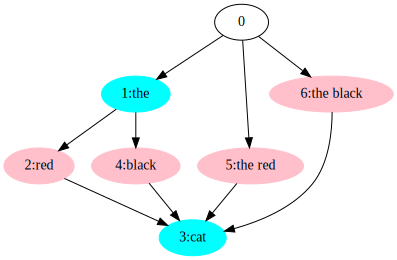

In [35]:
# Source: https://github.com/interedition/collatex/blob/master/collatex-pythonport/collatex/display_module.py
# node id values must be strings for graphviz
a = graphviz.Digraph(format="svg")
for key,value in decision_graph['nodes'].items():
    if value['id'] != 0:
        node_id = str(value['id'])
        if value['type'] == 'closest-in-one':
            fill_color = 'pink'
        elif value['type'] == 'closest-in-both':
            fill_color = 'cyan'
        else:
            fill_color = 'white'
        try:
            if value['type'] == 'skip':
                ngram_text = 'skip'
            else:
                ngram_text = value['aligned-patterns'][len(value['aligned-patterns']) - 1][2][0]
        except:
            ngram_text = 'oops'
        a.node(node_id, label=node_id + ':' + ngram_text, style='filled', color=fill_color)
for key,values in decision_graph['edges']['outgoing'].items(): # values is list of integers
    for value in values:
        a.edge(str(key), str(value))
SVG(a.view())

## Output table of paths, sorted from best to worst

Sort by, in order:

1. Aligned token count (high is better)
1. Path length (node count; low is better)
1. Transposition count (pattern count; low is better)

In [36]:
from IPython.display import HTML
evaluation_report = ['<table border><tr style="text-align:center;"><th>Leaf<br/>id</th><th>Aligned<br/>tokens</th><th>Path<br/>length</th><th>Transposed<br/>patterns</th></tr>']
evaluation_data = []
for key, value in decision_graph['nodes'].items():
    if not key in decision_graph['edges']['outgoing']: # it's a leaf node
        path_length = len(value['aligned-patterns'])
        token_count = 0 # counts tokens, not ngrams (nodes)
        transposition_count = 0 # counts nodes (not tokens)
        for t in value['aligned-patterns']:
            token_count += ngram_lengths[t[2][0]]
        for t in value['transposed-patterns']:
            transposition_count += 1
        evaluation_data.append((value['id'], token_count, path_length, transposition_count))
evaluation_data.sort(key = lambda x : (-x[1], x[2], x[3], x[0]))
for leaf in (evaluation_data):
    evaluation_report.append('<tr style="text-align:right;"><td>' + str(leaf[0]) + '</td><td>' + str(leaf[1]) + '</td><td>' + str(leaf[2]) + '</td><td>' + str(leaf[3]) + '</td></tr>')
evaluation_report.append('</table>')
HTML(''.join(evaluation_report))

Leafid,Alignedtokens,Pathlength,Transposedpatterns
3,3,3,4
